<a href="https://colab.research.google.com/github/sxqqslf/Compiler/blob/master/ResearchAndExpermentation/CustomTraining_walkthrougth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.12.0-rc2
Eager execution: True


In [26]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)
print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /root/.keras/datasets/iris_training.csv


In [27]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [28]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'sepcies']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Feature: {}".format(feature_names))
print("Label: {}".format(label_name))

Feature: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: sepcies


In [0]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [0]:
batch_size = 32
train_dataset = tf.contrib.data.make_csv_dataset(
  train_dataset_fp,
  batch_size,
  column_names=column_names,
  label_name=label_name,
  num_epochs=1)

In [31]:
features, labels = next(iter(train_dataset))
features

OrderedDict([('sepal_length',
              <tf.Tensor: id=337, shape=(32,), dtype=float32, numpy=
              array([5.4, 6.7, 5.9, 6.2, 6.6, 6.5, 4.9, 5.8, 5.5, 4.8, 5.7, 5.6, 4.6,
                     7.2, 5.4, 6.9, 6.3, 5.7, 4.9, 6.4, 6.7, 5.7, 4.6, 4.6, 7.7, 5.8,
                     4.8, 5.8, 6. , 6.5, 7.6, 5.6], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=338, shape=(32,), dtype=float32, numpy=
              array([3.7, 3. , 3.2, 2.8, 2.9, 3. , 3.1, 2.8, 3.5, 3. , 2.9, 2.7, 3.2,
                     3.2, 3. , 3.1, 3.3, 3.8, 3.1, 2.8, 3.1, 3. , 3.4, 3.1, 2.8, 4. ,
                     3.1, 2.7, 2.2, 3. , 3. , 2.9], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=335, shape=(32,), dtype=float32, numpy=
              array([1.5, 5. , 4.8, 4.8, 4.6, 5.5, 1.5, 5.1, 1.3, 1.4, 4.2, 4.2, 1.4,
                     6. , 4.5, 4.9, 6. , 1.7, 1.5, 5.6, 4.4, 4.2, 1.4, 1.5, 6.7, 1.2,
                     1.6, 5.1, 5. , 5.8, 6.6, 3.

Text(0,0.5,'Sepal length')

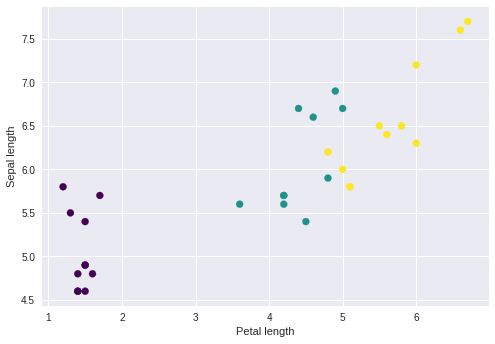

In [32]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')
plt.xlabel('Petal length')
plt.ylabel('Sepal length')

In [33]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

train_dataset = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[6.4 2.8 5.6 2.1]
 [6.5 2.8 4.6 1.5]
 [7.4 2.8 6.1 1.9]
 [5.7 3.8 1.7 0.3]
 [5.7 2.8 4.5 1.3]], shape=(5, 4), dtype=float32)


In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.564774513244629


In [37]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
global_step = tf.train.get_or_create_global_step()

loss_value, grads = grad(model, features, labels)
print("Step: {}, Initial loss: {}".format(global_step.numpy(), loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)
print("Step:{},          loss: {}".format(global_step.numpy(), 
                                          loss(model, features, labels).numpy()))

Step: 0, Initial loss: 1.564774513244629
Step:1,          loss: 1.3011043071746826


In [40]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()
  
  for x, y in train_dataset:
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables), global_step)
    
    epoch_loss_avg(loss_value)
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
    
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.062, Accuracy: 35.000%
Epoch 050: Loss: 0.332, Accuracy: 95.000%
Epoch 100: Loss: 0.211, Accuracy: 97.500%
Epoch 150: Loss: 0.143, Accuracy: 98.333%
Epoch 200: Loss: 0.162, Accuracy: 97.500%


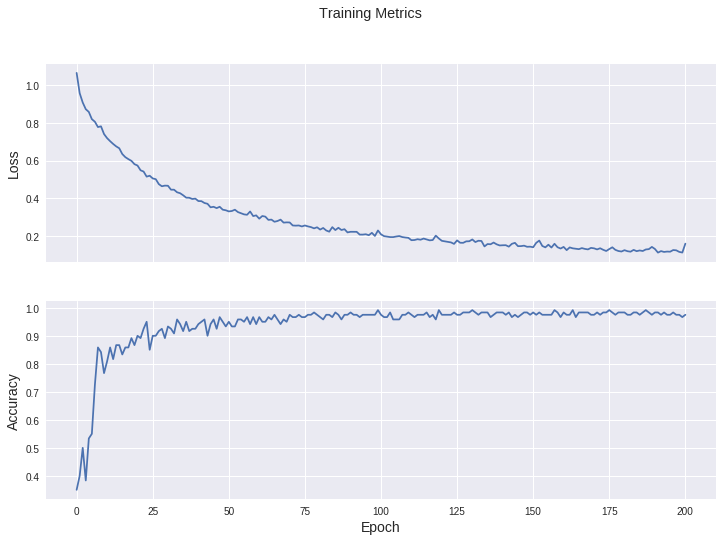

In [42]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel('Loss', fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].plot(train_accuracy_results)

In [43]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [0]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [50]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
tf.stack([y, prediction], axis=1)

Test set accuracy: 96.667%


<tf.Tensor: id=123488, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 1],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

In [51]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (98.1%)
Example 1 prediction: Iris versicolor (95.3%)
Example 2 prediction: Iris virginica (64.7%)
